# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

In [555]:
import numpy as np
import numpy.random as npr
import time
import warnings
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import missingno as msn

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
npr.seed(1)

In [301]:
# Global variables & constants
_MAX_STEPS = int(1e5)

# Defining the available numerical schemes
Scheme = Enum('Scheme', ["EULER", "MILSTEIN"])

## Interest rates modelling

### Vasicek

In [238]:
# Function to explicitly cast a dictionary or Numpy array into a pandas DataFrame
cast_df = lambda x: pd.DataFrame(x)

In [398]:
class VasicekModel:
    def __init__(self, r0: float, kappa: float, theta: float, eta: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and eta > 0
        
        # Storing variable
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"Vasicek model {model.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"Vasicek model {model.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\eta$ = {self.eta})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"

    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
            
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.eta*dW[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) = 0, the Milstein scheme is equivalent to the Euler scheme
        return self.simulate_euler(T, N)

In [570]:
# Default Vasicek model
model = VasicekModel(0.01875, 0.20, 0.01, 0.012)

In [571]:
# Displaying information on Vasicek model
model

Vasicek model (r0 = 0.01875, kappa = 0.2, theta = 0.01, eta = 0.012))

In [572]:
# Casting the results into a pandas DataFrame
df = cast_df(model.simulate_euler(T = 2))

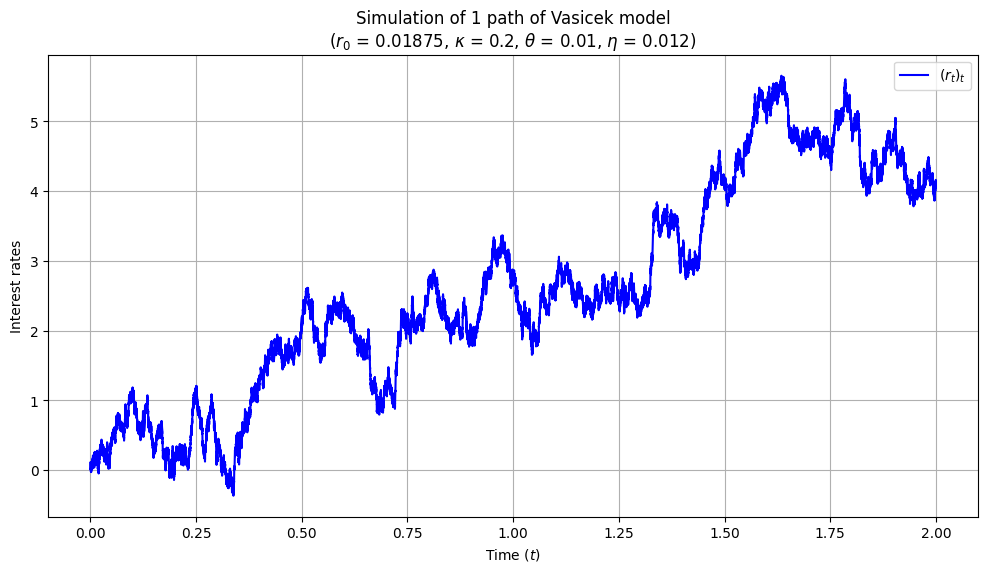

In [573]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

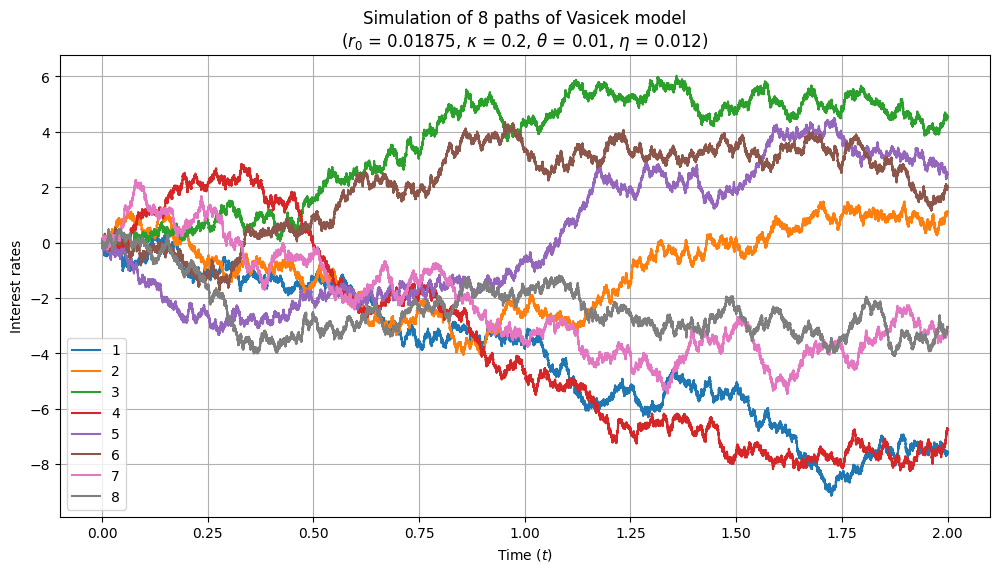

In [574]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

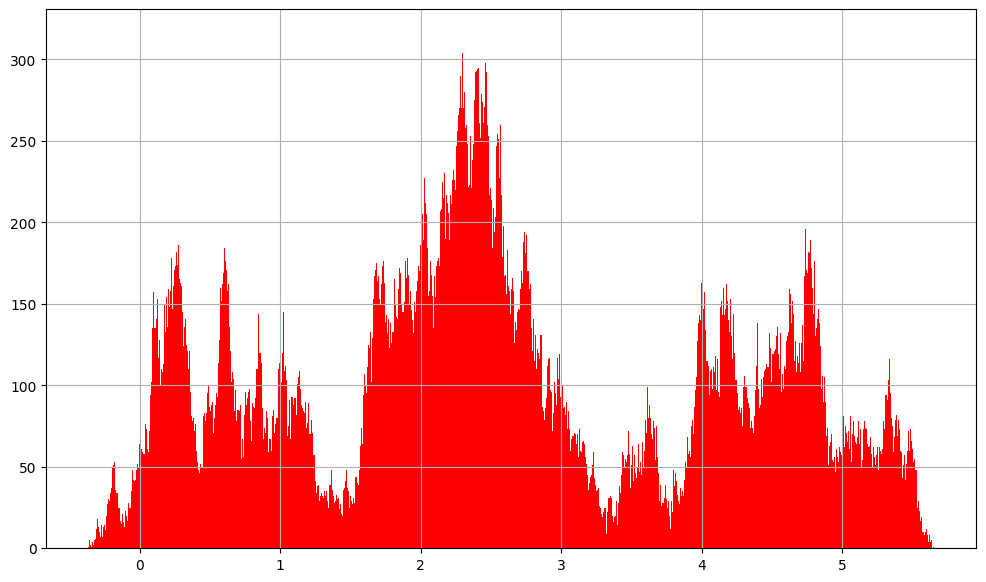

In [576]:
_ = df["r"].hist(bins=1000, figsize=(12, 7), color="red")

In [577]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

### Cox-Ingersoll-Ross (CIR)

In [578]:
class CIRModel:
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and sigma > 0
        
        # Verifying the Feller condition
        self.feller_condition = 2*kappa*theta >= sigma**2
        if self.feller_condition:
            print("(r_t)_t strictly positive")
        
        # Storing variables
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"CIR model {model.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"CIR model {model.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\sigma$ = {self.sigma})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, sigma = {self.sigma})"
    
    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_milstein(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
    
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following CIR model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.sigma*np.sqrt(r[t])*dW[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following CIR model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) <> 0, the Milstein scheme is not equivalent to the Euler scheme
        # and a complete implementation is required !
        
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] \
                     + self.kappa*(self.theta - r[t])*dT  \
                     + self.sigma*np.sqrt(r[t])*dW[t] \
                     + (1/2)*(dW[t]**2 - dT)*(self.sigma*np.sqrt(r[t]))*(self.sigma)/(2*np.sqrt(r[t]))
        return {"t": H, "r":r}
        
    def plot_feller_line(self, **kwards) -> None:
        """
        Function printing the Feller line to highlight the positivity of simulated rates
        """
        if self.feller_condition:
            plt.axhline(y=0, color="m", ls="-.", alpha=0.7, **kwards, label="Feller line")
            _ = plt.legend()
    

In [565]:
# Default CIR model
model = CIRModel(0.01875, 0.20, 0.01, 0.012)

(r_t)_t strictly positive


In [566]:
# Displaying information on Vasicek model
model

CIR model (r0 = 0.01875, kappa = 0.2, theta = 0.01, sigma = 0.012))

In [567]:
# Casting the results into a pandas DataFrame
df = cast_df(model.simulate_milstein(T=3))

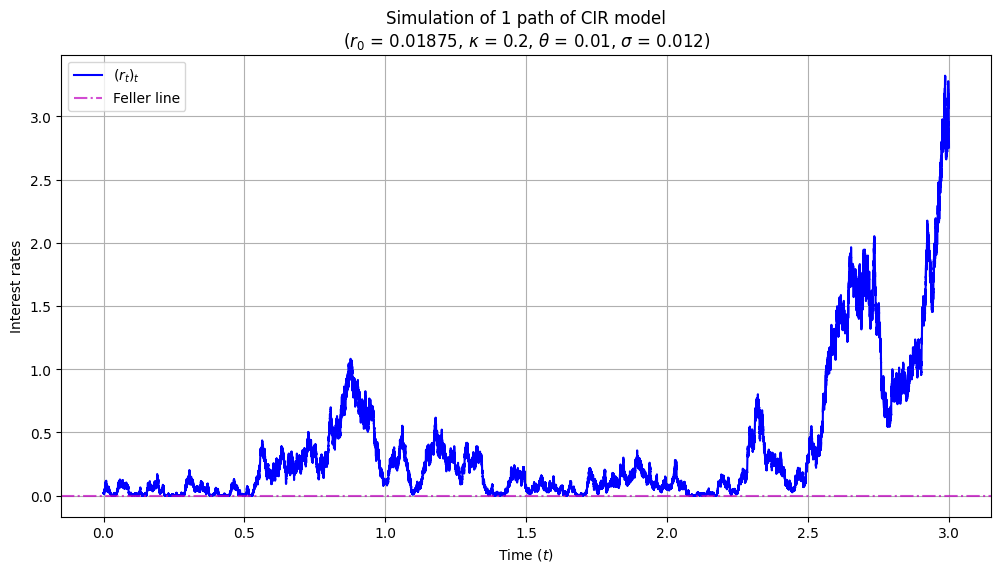

In [568]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of CIR model\n{model.get_parameter_string()}")
model.plot_feller_line()

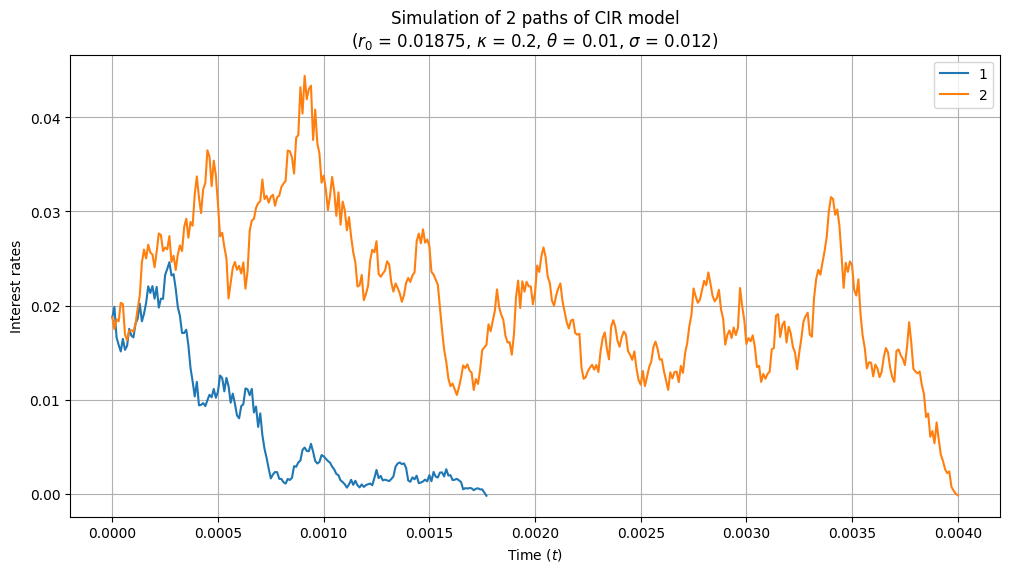

In [569]:
# Simulation of several trajectories
NB_TRAJECTORIES = 2
_ = cast_df(model.simulate_paths(NB_TRAJECTORIES, scheme=Scheme.EULER)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

In [557]:
a = cast_df(model.simulate_paths(NB_TRAJECTORIES)).T

<AxesSubplot:>

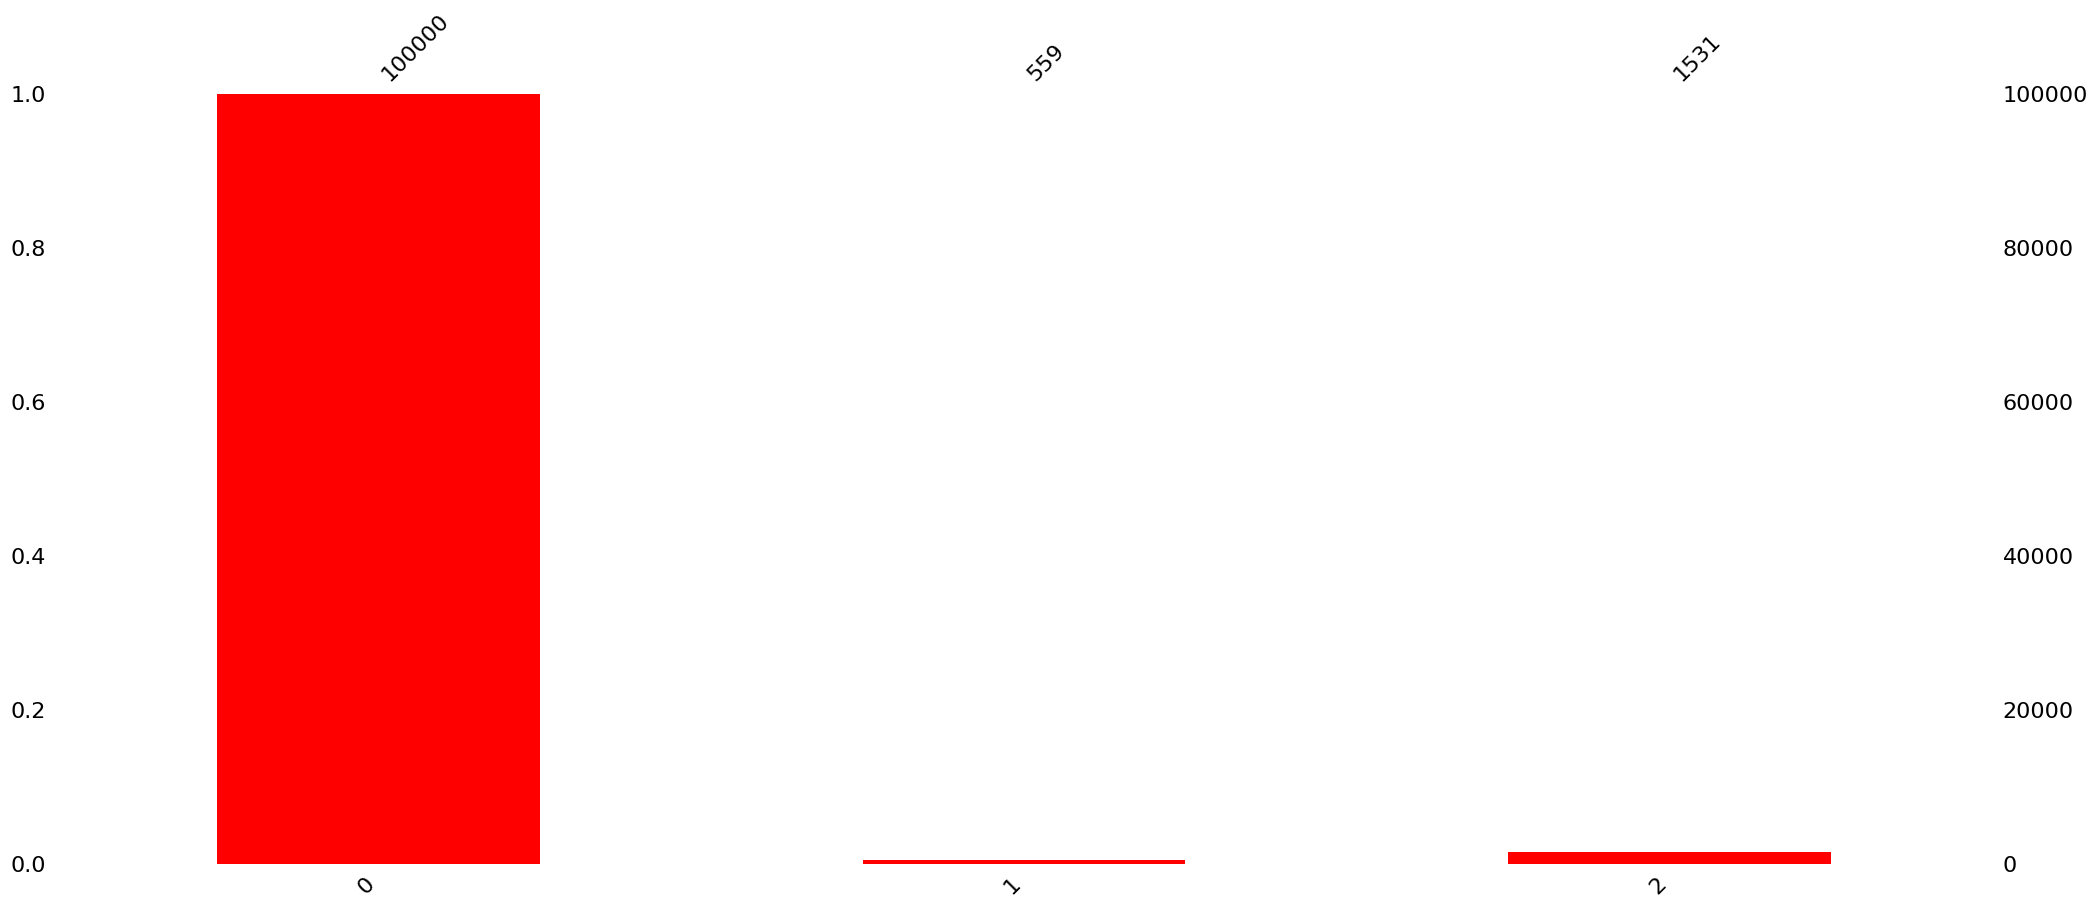

In [563]:
msn.bar(a, color="red")

### Hull & White (HW) $\diamond$ Extended Vasicek

### Black–Karasinski

## Equity modelling

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Constant drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

## Analysis

### Distribution of $S_T$

### Computation of derivatives price

## Miscellaneous

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

### Model refinement $\longrightarrow$ Constant to time-varying parameters

#### <u>Interest rates dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \theta(t)$ instead of $\theta \in \mathbb{R}^+$</span>

#### <u>Equity index dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \sigma(t)$ instead of $\sigma \in \mathbb{R}^+$</span>

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
